## Auto Encoder

Let us try and train an Auto Encoder on our favorite MNIST dataset.

In [1]:
import torch
import torchmetrics
import torchvision
import pytorch_lightning as pl
from torch import nn
from torchvision import datasets, transforms
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule, Trainer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
pl.seed_everything(42)

Global seed set to 42


42

As usual, our first step is to create the DataModule. We will re-use the same datamodule that we had used for the classification problem. 

In [3]:
%run 14-common-mnist-data-module.ipynb

Now let us define a simple AutoEncoder architecture.

We will implement 2 encoder-decoder setups
1. A convolution layer based encoder-decoder
2. A simple linear layer based encoder-decoder

In [4]:
class ConvEncoder(nn.Module):
    def __init__(self, nz, img_shape):
        super(ConvEncoder, self).__init__()
        self.nz = nz
        in_channels, h, w = img_shape
        
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1), #(batch_size, 32, h, w)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2), #(batch_size, 32, h/2, w/2)
            nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1), #(batch_size, 128, h/2, w/2)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),  #(batch_size, 128, h/4, w/4)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), #(batch_size, 256, h/4, w/4)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #(batch_size, 256, h/8, w/8)
            nn.Flatten()
        ) 
        conv_out_size = 256 * int(h / 8) ** 2
        
        # The parameters mu and log variance
        self.fc = torch.nn.Linear(conv_out_size, nz)
        
    def forward(self, x):
        """
        Input:  X -> (batch_size, c, h, w) tensor 
        Output: z -> (batch_size, nz) tensor
        """
        conv_out = self.conv_encoder(X)
        z = self.fc(conv_out)
        return z
    
class ConvDecoder(nn.Module):
    def __init__(self, nz, img_shape):
        super(ConvDecoder, self).__init__()
        self.nz = nz
        in_channels, h, w = img_shape
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.nz, out_channels=256, kernel_size=4, 
                               stride=1, padding=0, bias=False), #(batch_size, 256, h/8, w/8)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, 
                               stride=2, padding=0, bias=False), #(batch_size, 128, h/4, w/4)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 32, kernel_size=2, 
                               stride=2, padding=0, bias=False), #(batch_size, 32, h/2, w/2)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, in_channels, kernel_size=2, 
                               stride=2, padding=0, bias=False), #(batch_size, 3, h, w)
            nn.Sigmoid(),
        )
        
    def forward(self, z):
        """
        This method is responsible for decoding. 
        Input:   z -> (batch_size, nz) tensor
        Output: Xr -> (batch_size, c, h, w) tensor i.e the reconstructed image
        """
        # The input is a (batch_size, nz) tensor. We convert it into (batch_size, nz, 1, 1) tensor.
        Xr = self.decoder(z.view(z.shape[0], z.shape[1], 1, 1))
        return Xr

In [5]:
class LinearEncoder(nn.Module):
    def __init__(self, nz, img_shape):
        super(LinearEncoder, self).__init__()
        self.nz = nz
        in_channels, h, w = img_shape
        self.base_encoder = torch.nn.Sequential(
            torch.nn.Flatten(), # Flatten the image tensor from (batch_size, c, h, w) to (batch_size, c*h*w)
            torch.nn.Linear(in_channels*h*w , 512), # (batch_size, 512)
            torch.nn.ReLU(True),
        )        
        self.fc = torch.nn.Linear(512, nz)
        
    def forward(self, X):
        """
        Input:  X -> (batch_size, c, h, w) tensor 
        Output: z -> (batch_size, nz) tensor
        """
        encoder_out = self.base_encoder(X)
        z = self.fc(encoder_out)
        return z
    
class LinearDecoder(nn.Module):
    def __init__(self, nz, img_shape):
        super(LinearDecoder, self).__init__()
        self.nz = nz
        self.img_shape = img_shape
        in_channels, h, w = img_shape
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(nz, 512),
            torch.nn.ReLU(True),
            torch.nn.Linear(512, in_channels*h*w),
            torch.nn.Sigmoid(),
        )
        
    def forward(self, z):
        """
        This method is responsible for decoding. 
        Input:   z -> (batch_size, nz) tensor
        Output: Xr -> (batch_size, c, h, w) tensor i.e the reconstructed image
        """
        Xr = self.decoder(z).reshape(-1, self.img_shape[0], self.img_shape[1], self.img_shape[2])
        return Xr

In [6]:
class AutoEncoder(LightningModule):
    def __init__(self, nz, backbone="linear", img_shape=(1, 32, 32)):
        super(AutoEncoder, self).__init__()
        self.save_hyperparameters()
        
        self.nz = nz
        self.img_shape = img_shape
        
        assert backbone in ["linear", "conv"], f"{backbone} must be one of linear/conv"
        
        if backbone == "linear":
            self.encoder = LinearEncoder(nz, img_shape)
            self.decoder = LinearDecoder(nz, img_shape)
        else:
            self.encoder = ConvEncoder(nz, img_shape)
            self.decoder = ConvDecoder(nz, img_shape)
        
        # We will use MeanSquaredError
        self.criterion = torch.nn.MSELoss(reduction="sum")
        
    
    def core_step(self, X):
        z = self.encoder(X)
        Xr = self.decoder(z)
        loss = self.criterion(Xr, X)
        return loss
    
    def training_step(self, batch, batch_idx):
        """
        This method implements the basic training step. We will run forward pass, compute 
        loss. We will log any necessary values, and return the total loss.
        """
        X, _ = batch # We don't care about the target for unsupervised learning
        loss = self.core_step(X)
        if self.global_step % 100 == 0:
            self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx, dataset_idx=None):
        """
        This method implements the basic validation step. We will run the forward pass, compute the loss
        and return it.
        """
        X, _ = batch
        return self.core_step(X)
    
    def validation_epoch_end(self, outputs):
        """
        This method will be called at the end of all test steps for each epoch i.e the validation epoch end.
        The output of every single test_step is available to via outputs. 
        
        """
        avg_loss = torch.tensor(outputs).mean()
        self.log("val_loss", avg_loss)
        print(f"Epoch {self.current_epoch}, Val loss: {avg_loss:0.2f}")
        return avg_loss
    
        
    def configure_optimizers(self):
        """
        The optimizer will be configured in this method
        """
        return torch.optim.Adam(model.parameters())
    
    def checkpoint_callback(self):
        """
        This callback determines the logic for how we want to checkpoint / save the model
        """
        # We will save the model with the lowest val loss.
        return ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)

In [7]:
dm = MNISTDataModule()
# We will use a simple setup in order to train fast. The reader is encouraged to play around
# with different parameters.

nz = 2
model = AutoEncoder(nz=nz, backbone="linear", img_shape=(1, 32, 32))

In [8]:
exp_dir = "/tmp/mnist_autoencoder/"
checkpoint_callback = model.checkpoint_callback()
 
trainer = Trainer(
        default_root_dir=exp_dir, # The experiment directory
        callbacks=[checkpoint_callback],
        gpus=torch.cuda.device_count(), # Number of GPUs to run on
        max_epochs=20,
        num_sanity_val_steps=0
    )
trainer.fit(model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]


  | Name      | Type          | Params
--------------------------------------------
0 | encoder   | LinearEncoder | 525 K 
1 | decoder   | LinearDecoder | 526 K 
2 | criterion | MSELoss       | 0     
--------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.211     Total estimated model params size (MB)


Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



/Users/sujaynarumanchi/.virtualenvs/book_test_pyt113/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/sujaynarumanchi/.virtualenvs/book_test_pyt113/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, Val loss: 3998.33


Validating: 0it [00:00, ?it/s]

Epoch 1, Val loss: 3802.08


Validating: 0it [00:00, ?it/s]

Epoch 2, Val loss: 3691.82


Validating: 0it [00:00, ?it/s]

Epoch 3, Val loss: 3611.56


Validating: 0it [00:00, ?it/s]

Epoch 4, Val loss: 3576.77


Validating: 0it [00:00, ?it/s]

Epoch 5, Val loss: 3527.84


Validating: 0it [00:00, ?it/s]

Epoch 6, Val loss: 3491.77


Validating: 0it [00:00, ?it/s]

Epoch 7, Val loss: 3468.66


Validating: 0it [00:00, ?it/s]

Epoch 8, Val loss: 3425.93


Validating: 0it [00:00, ?it/s]

Epoch 9, Val loss: 3410.74


Validating: 0it [00:00, ?it/s]

Epoch 10, Val loss: 3384.06


Validating: 0it [00:00, ?it/s]

Epoch 11, Val loss: 3353.31


Validating: 0it [00:00, ?it/s]

Epoch 12, Val loss: 3361.84


Validating: 0it [00:00, ?it/s]

Epoch 13, Val loss: 3333.76


Validating: 0it [00:00, ?it/s]

Epoch 14, Val loss: 3330.17


Validating: 0it [00:00, ?it/s]

Epoch 15, Val loss: 3327.99


Validating: 0it [00:00, ?it/s]

Epoch 16, Val loss: 3309.20


Validating: 0it [00:00, ?it/s]

Epoch 17, Val loss: 3286.25


Validating: 0it [00:00, ?it/s]

Epoch 18, Val loss: 3279.66


Validating: 0it [00:00, ?it/s]

Epoch 19, Val loss: 3267.60


## Visualizing the latent space 

Let us try and visualize how the latent embeddings look like.

If the embedding size is small, we can directly plot the embeddings. However if our embedding size is large, we utilize t-SNE for visualization.

t-SNE is a tool to visualize high-dimensional data. It tries to learn a low dimensional embedding from a high dimensional embeddings such that the Kullback-Leibler (KL) divergence between the the joint probabilities of the low-dimensional embedding and the high-dimensional data is minimized.  

To visualize the latent space, we will need to extract embeddings first.

In [9]:
best_model_path = checkpoint_callback.best_model_path
# Let us load the model from the best model weights that we have
trained_model = AutoEncoder.load_from_checkpoint(best_model_path)
trained_model.eval()

val_dataloader = dm.val_dataloader()

In [10]:
embeddings = []
targets = []
num_batches = 50
for i, batch in enumerate(val_dataloader):
    X, y_gt  = batch
    z = trained_model.encoder(X)
    embeddings.append(z.detach())
    targets.append(y_gt.detach())
embeddings = torch.cat(embeddings)
targets = torch.cat(targets)

In [11]:
def plot_embeddings(embeddings, gt_labels):
    colors = [
        "r",
        "g",
        "b",
        "c",
        "m",
        "y",
        "k",
        "orange",
        "purple",
        "cyan",
        "indigo",
        "pink",
    ]
    all_classes = set([x.item() for x in gt_labels])
    colors = colors[: len(all_classes)]
    plt.figure(figsize=(7, 7), dpi=200)
    for i, cls in enumerate(all_classes):
        cls_embeddings = embeddings[[x for x in range(len(gt_labels)) if gt_labels[x] == cls]]
        plt.scatter(cls_embeddings[:, 0], cls_embeddings[:, 1], c=colors[i], label=cls)
    plt.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0.0)

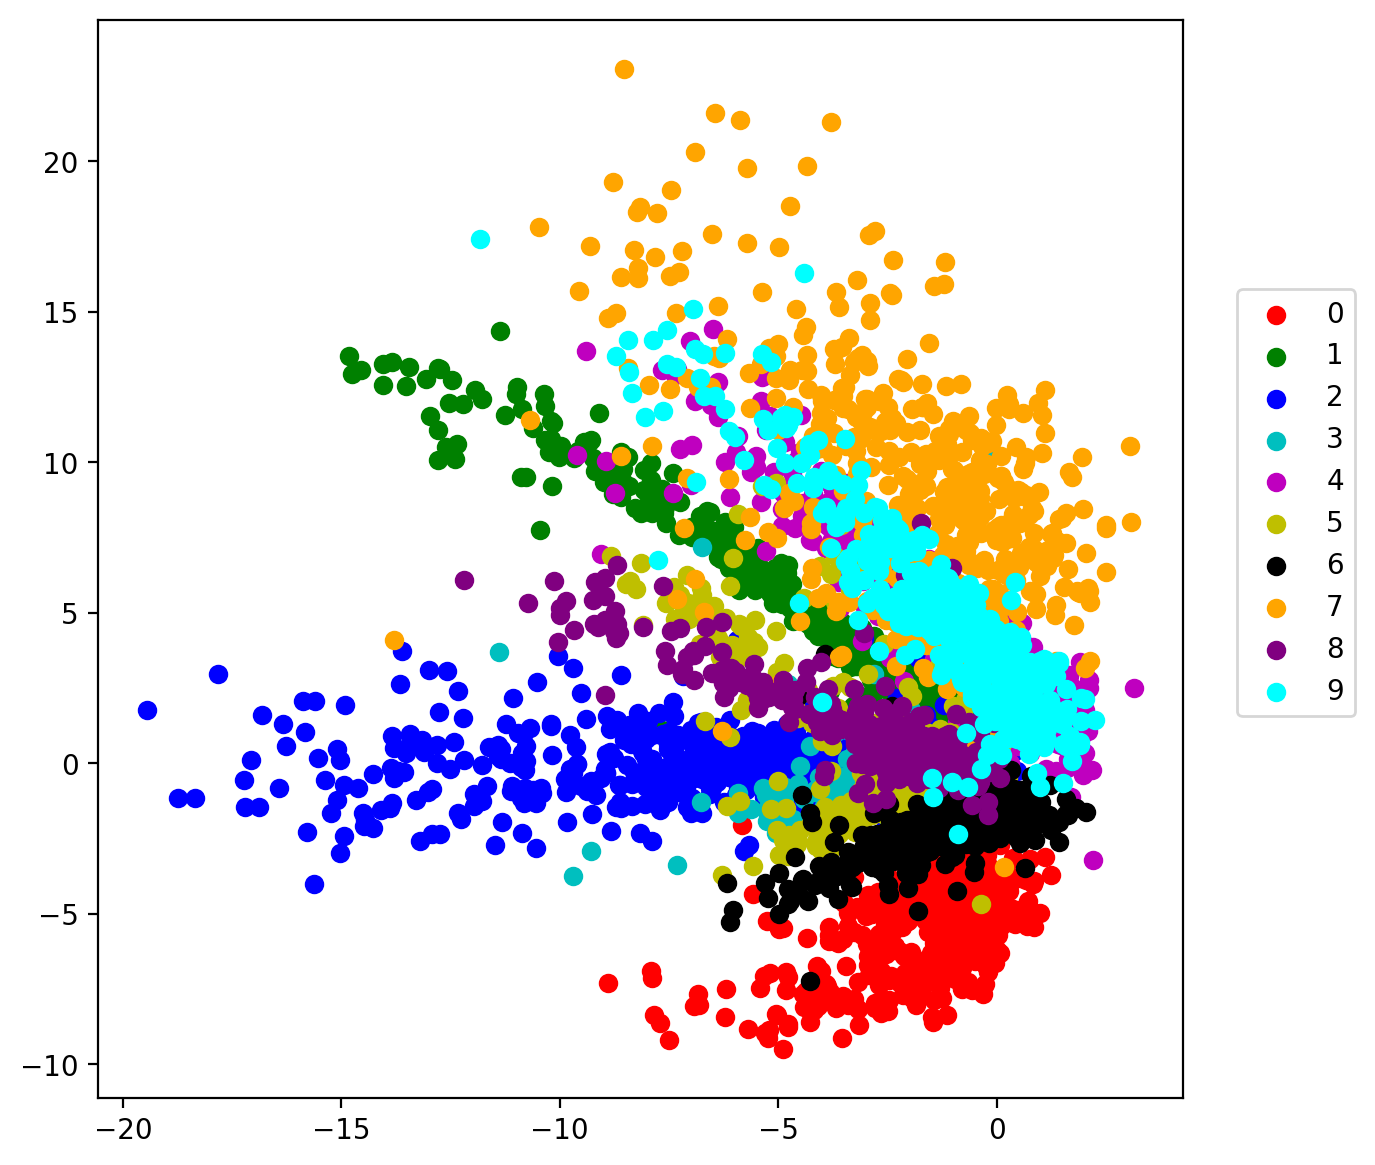

In [12]:
if nz == 2:
    # We can directly plot the embeddings
    plot_embeddings(embeddings, targets)
elif nz > 2:
    tsne_embeddings = TSNE().fit_transform(embeddings)
    plot_embeddings(tsne_embeddings, targets)
else: 
    raise NotImplementedError(f"{nz} not supported")

## Reconstructed images

In [13]:
X, _ = next(iter(val_dataloader))
z = trained_model.encoder(X).detach()
Xr = trained_model.decoder(z).detach()

Let us first take a look at the original images

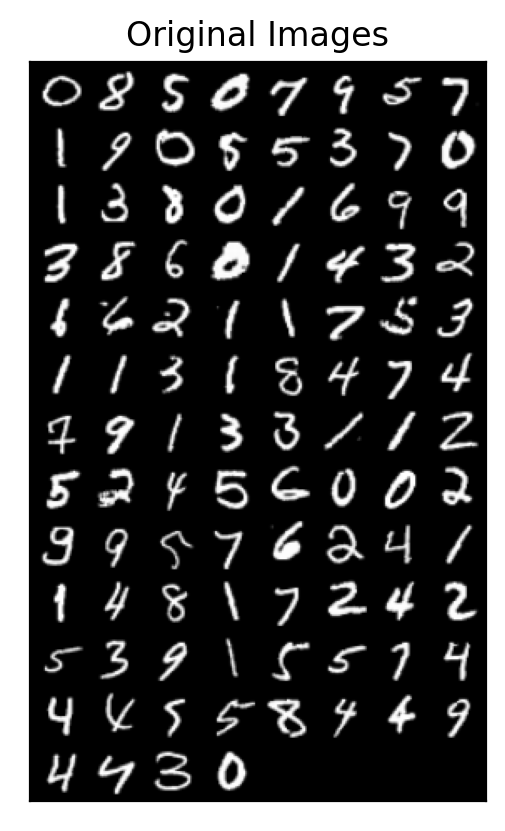

In [14]:
x_grid = torchvision.utils.make_grid(X)
plt.figure(dpi=200)
plt.imshow(x_grid.numpy().transpose((1, 2, 0)))
plt.title("Original Images")
plt.xticks([])
plt.yticks([])
plt.show()

Let us first now take a look at the corresponding reconstructed images

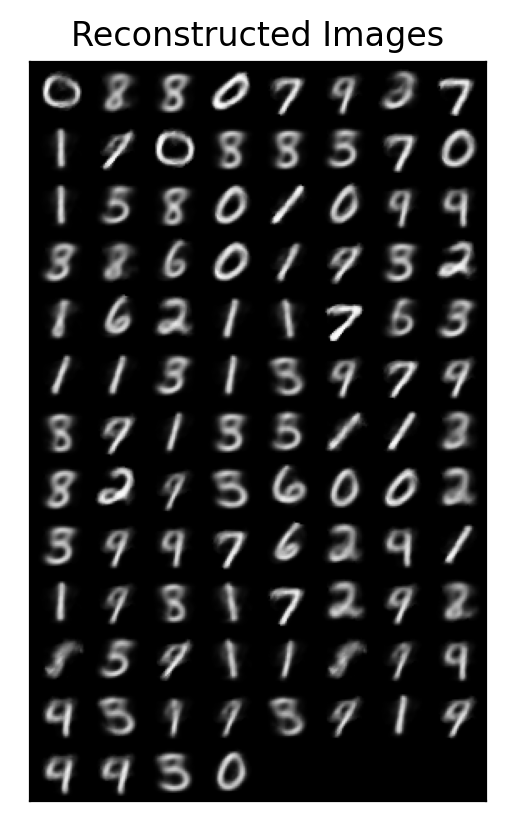

In [15]:
xr_grid = torchvision.utils.make_grid(Xr)
plt.figure(dpi=200)
plt.imshow(xr_grid.numpy().transpose((1, 2, 0)))
plt.title("Reconstructed Images")
plt.xticks([])
plt.yticks([])
plt.show()